In [3]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
#SIMOUT_DIR = os.path.join(GIMME_DIR, "1d_sims/")
SIMOUT_DIR = GIMME_DIR + "/1d_sims/"
OBSERVED_FILE = os.path.join(GIMME_DIR, "empirical_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

In [ ]:
## Gather all the simulations from all the running hosts, assumes you're running on cattywampus
## Assumes you have sshpass installed
hosts = {"yowie":"isaac", "yeti":"isaac", "trashquatch":"labuser", "enterprise":"iovercast", "goatzilla":"isaac"}
passwd = {"yowie":"aardvark1", "yeti":"zastards", "trashquatch":"hickerlab", "enterprise":"watwatwat", "goatzilla":"hickerlab"}
simdir = {"yowie":"/Users/isaac/work/",
          "yeti":"/Volumes/WorkDrive/",
          "trashquatch":"/Users/labuser/Documents/isaac/",
          "enterprise":"/home/iovercast/",
          "goatzilla":"/home/isaac/"}

for host in hosts.keys():
    cmd = "sshpass -p \"{}\" scp -r {}@{}:{}gimmeSAD/1d_sims/* /tmp/sims/".format(passwd[host], hosts[host], host, simdir[host])
    print(cmd)
    os.system(cmd)


sshpass -p "aardvark1" scp -r isaac@yowie:/Users/isaac/work/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "watwatwat" scp -r iovercast@enterprise:/home/iovercast/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r labuser@trashquatch:/Users/labuser/Documents/isaac/gimmeSAD/1d_sims/* /tmp/sims/
sshpass -p "hickerlab" scp -r isaac@goatzilla:/home/isaac/gimmeSAD/1d_sims/* /tmp/sims/


## Gather all the simulations into one huge simout file

In [41]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = False
REGULARIZE = False
DROPEQUILIBSIMS = True

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = " ".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines)]
    ## Don't write blanks
    if lines:
        numsims += len(lines)
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 1135578 simulations.


In [291]:
new_lines[0]
print(numsims)


14640


## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [6]:
REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")

In [7]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS)

/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: abc.data

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: nnet

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: quantreg

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SparseM

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘SparseM’


  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘packag

     K          c   step   X.equil    colrate     extrate  shannon bin_0 bin_1
1 5186 0.01059815 340000 0.5566911 0.01066471 0.004452941 3.359688    87    55
  bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     6     1     0     0     1     0     0     0
   shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 3.737537     8    25     7     4     1     3     2     4     1     2


In [262]:
%%R
## Do or don't regularize the observed pi bins
if(TRUE){
    shan = OBS[1]
    tot = sum(OBS[2:11])
    OBS = data.frame(c(shan, OBS[2:11]/tot))
    print(OBS)
}

   shannon     bin_0     bin_1    bin_2      bin_3      bin_4      bin_5
1 3.737537 0.1403509 0.4385965 0.122807 0.07017544 0.01754386 0.05263158
       bin_6      bin_7      bin_8      bin_9
1 0.03508772 0.07017544 0.01754386 0.03508772


## Estimate % equilibrium using shannon index and 1d pi vector


### Rejection

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.2979760
0.01  0.2916369
0.05  0.3408845


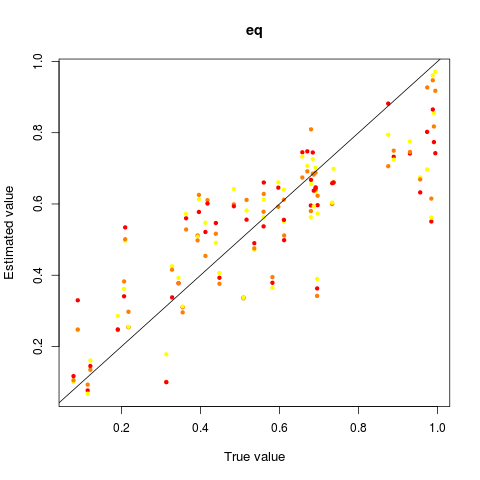

In [36]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(0.005,.05,.01), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.3551522
0.01  0.2361144
0.05  0.2130030


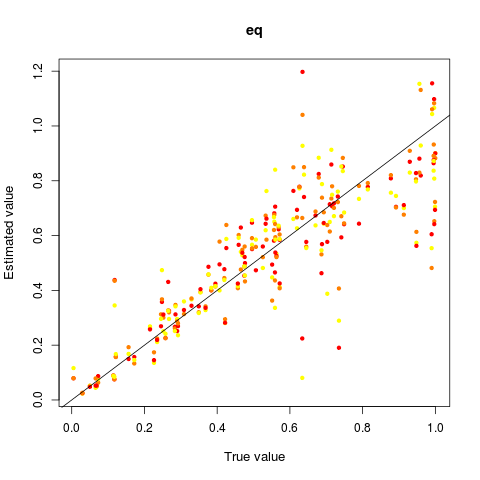

In [37]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Results with pi vectors regularized to sum to 1

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Do the ABC

12345
12345
Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.04, method = "neuralnet", 
    numnet = 5, lambda = 0.1)
Data:
 abc.out$adj.values (1314 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.6499
Weighted 2.5 % Perc.:  0.7635
Weighted Median:       0.8711
Weighted Mean:         0.8729
Weighted Mode:         0.8475
Weighted 97.5 % Perc.: 0.9892
Max.:                  1.0907
                              eq
Min.:                  0.6498956
Weighted 2.5 % Perc.:  0.7634873
Weighted Median:       0.8710776
Weighted Mean:         0.8728797
Weighted Mode:         0.8474964
Weighted 97.5 % Perc.: 0.9891534
Max.:                  1.0907003


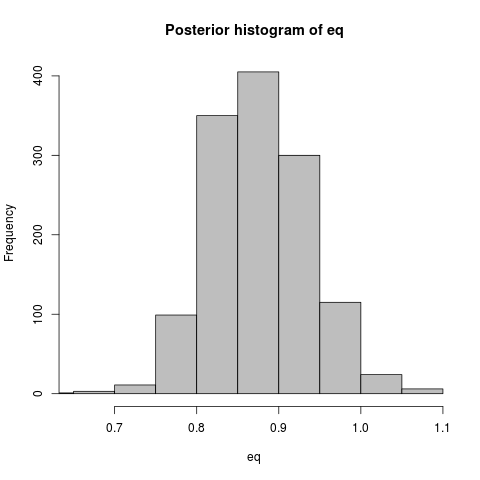

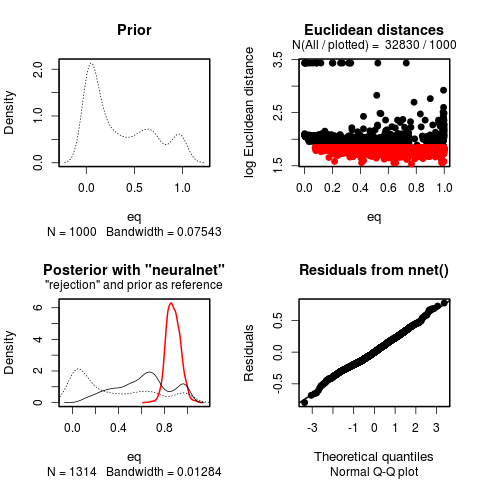

In [138]:
%%R
resboth.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.04,
                  method="neuralnet", lambda=0.1, numnet=5)
print(summary(resboth.abc))
hist(resboth.abc)
plot(resboth.abc, param=PRIOR[,"X.equil"])


0.875827873254
[ 0.76987096  0.9979726 ]


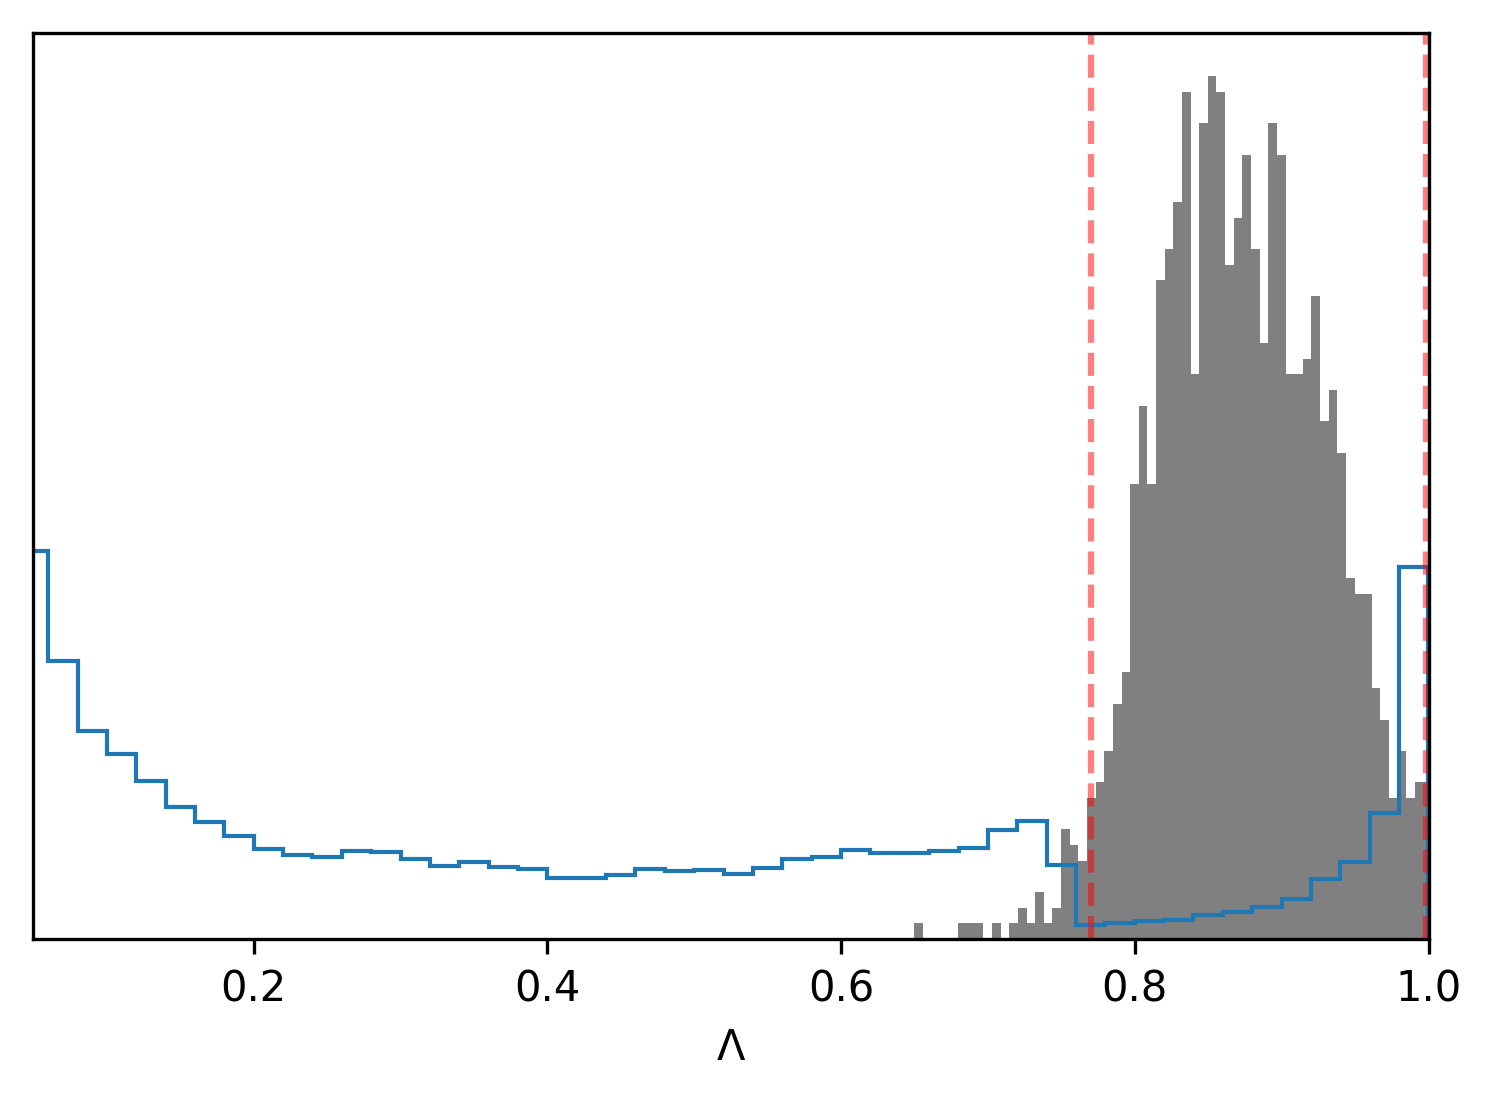

In [145]:
%R -o out out=resboth.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
print(np.mean(eqs))
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)
xs = pymc3.stats.hpd(eqs)[0]
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.5)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.5)
plt.xlabel(u"Λ")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True)
plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

In [316]:
%%R
res.abc$ss

        shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,] 3.257509    76    40     6     4     2     3     2     3     0     2
  [2,] 2.955322    42    35     8     4     0     1     4     2     0     2
  [3,] 3.447879    40    29    10     2     0     2     2     4     1     2
  [4,] 3.062392    51    44     5     6     0     2     2     2     0     1
  [5,] 3.251002    60    43     4     6     0     0     1     4     1     1
  [6,] 3.409516    72    55     9     3     1     2     3     2     1     2
  [7,] 2.131541    37    33     4     4     2     2     3     3     1     1
  [8,] 3.445052    36    36    14     5     4     3     1     4     0     1
  [9,] 2.890917    42    38     3     2     1     3     1     2     0     1
 [10,] 2.945705    19    19    12     4     1     1     0     3     0     1
 [11,] 3.072906    59    58    12     5     2     3     1     2     1     2
 [12,] 3.454007    50    37     9     2     2     3     1     3     1     1
 [13,] 2.712

## Estimate colonization rate using shannon index and 1d pi vector

Prediction error based on a cross-validation sample of 50

              eq
0.005 0.10610219
0.01  0.09760246
0.05  0.09416348


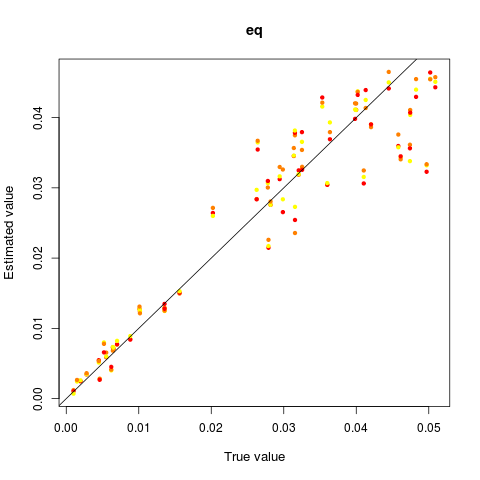

In [47]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.005, .01, 0.05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.001, method = "loclinear")
Data:
 abc.out$adj.values (1136 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                  -0.0087
Weighted 2.5 % Perc.:  -0.0030
Weighted Median:        0.0014
Weighted Mean:          0.0016
Weighted Mode:          0.0004
Weighted 97.5 % Perc.:  0.0082
Max.:                   0.0208
                             colrate
Min.:                  -0.0086795499
Weighted 2.5 % Perc.:  -0.0030392260
Weighted Median:        0.0013824708
Weighted Mean:          0.0016322893
Weighted Mode:          0.0004381777
Weighted 97.5 % Perc.:  0.0082199336
Max.:                   0.0208180124


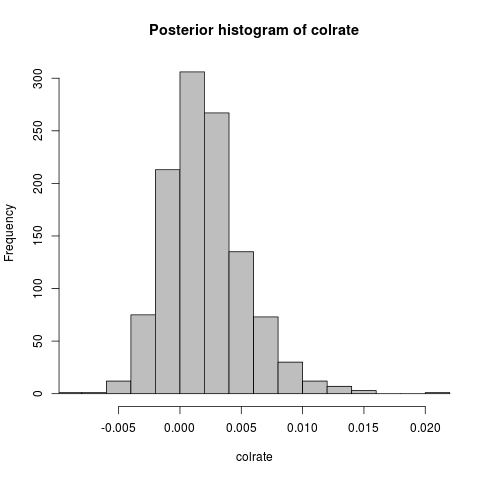

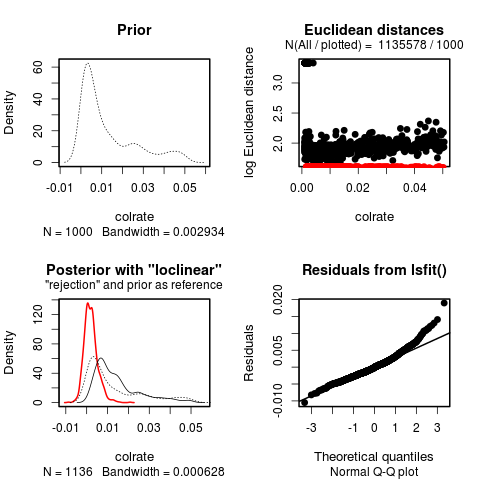

In [92]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.001, method="loclinear")
print(summary(res.abc))
hist(res.abc)
plot(res.abc, param=PRIOR[,"colrate"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 100

           shan
0.005 0.1647039
0.01  0.1630450
0.05  0.1549780


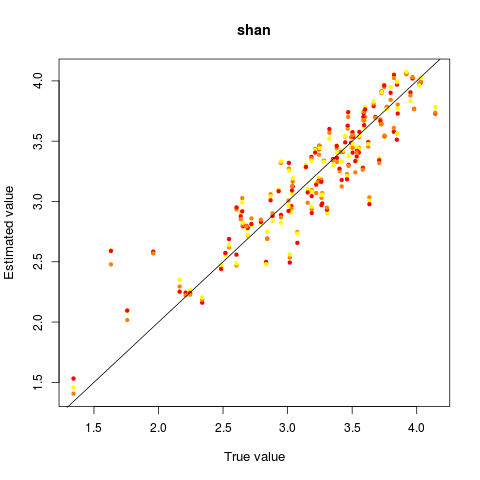

In [49]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=100, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 8:17], tol = 0.03, method = "rejection")
Data:
 abc.out$unadj.values (433 posterior samples)

               shan
Min.:        1.8891
2.5% Perc.:  2.2633
Median:      2.9991
Mean:        2.9931
Mode:        3.0066
97.5% Perc.: 3.7513
Max.:        4.0234
                 shan
Min.:        1.889086
2.5% Perc.:  2.263270
Median:      2.999063
Mean:        2.993113
Mode:        3.006599
97.5% Perc.: 3.751335
Max.:        4.023448


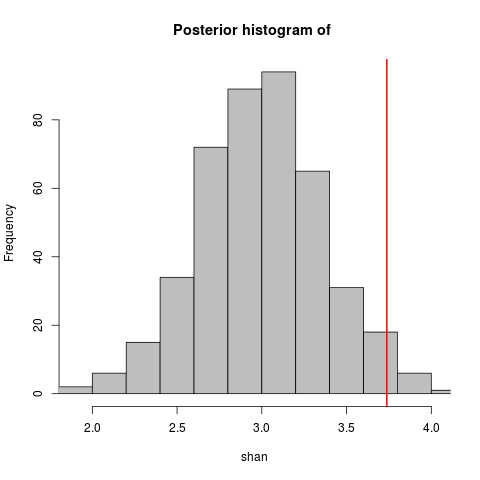

In [9]:
%%R
## w/o 'veil line'
res1d.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17], tol=0.03, method="rejection")
## w/ veil line
#res1d.abc = abc(target=OBS[3:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,9:17], tol=0.04, method="loclinear")
print(summary(res1d.abc))
hist(res1d.abc, true=3.737537, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

In [13]:
%R -o out out=res1d.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([float(x) for x in open(OBSERVED_FILE).readlines()[1].split()[:1]])[0]
print(OBS)
#print(out.shape)
shans = np.array(out[0])
print(np.mean(shans))
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)
plt.axvline(OBS, color='r', linestyle='-')
xs = pymc3.stats.hpd(shans)[0]
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.5)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.5)
plt.xlabel("H'")
## Truncate to make it look nicer
plt.xlim((0.5, 4.1))
plt.hist(shan_dat, bins=50, histtype="step", normed=True)
plt.savefig("/home/isaac/gimmeSAD/spider-posterior.svg")

ImportError: cannot import name nvcc_compiler

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.005 0.8224691
0.01  0.7990269
0.05  0.8442589


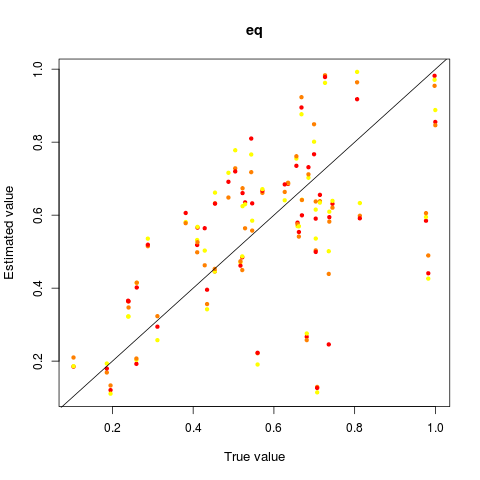

In [50]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,9:17], nval=50, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

### Would be good to implement a 'veil line' for undetected species in the empirical dataset

We can fake this by just dropping the singleton bin, here's the code w/o the veil line

`res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.05, method="neuralnet")`

12345678910
12345678910
Call: 
abc(target = OBS[3:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 9:17], tol = 0.04, method = "neuralnet")
Data:
 abc.out$adj.values (577 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.9182
Weighted 2.5 % Perc.:  0.9310
Weighted Median:       0.9536
Weighted Mean:         0.9517
Weighted Mode:         0.9603
Weighted 97.5 % Perc.: 0.9728
Max.:                  0.9914
                              eq
Min.:                  0.9181703
Weighted 2.5 % Perc.:  0.9309617
Weighted Median:       0.9536269
Weighted Mean:         0.9517214
Weighted Mode:         0.9603139
Weighted 97.5 % Perc.: 0.9728314
Max.:                  0.9914459


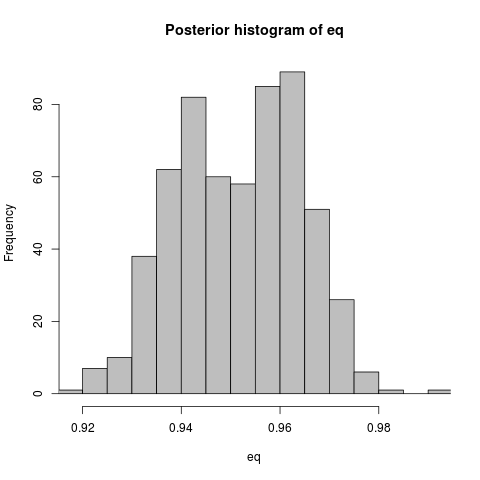

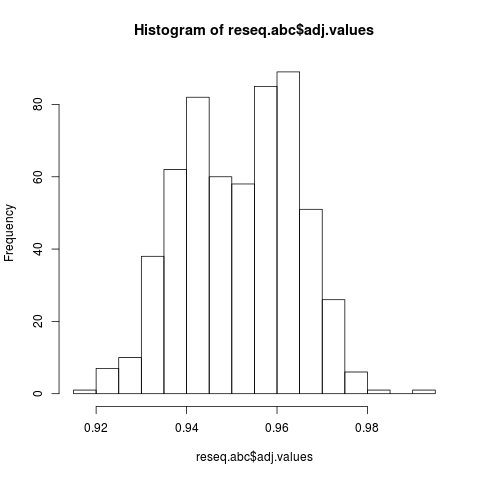

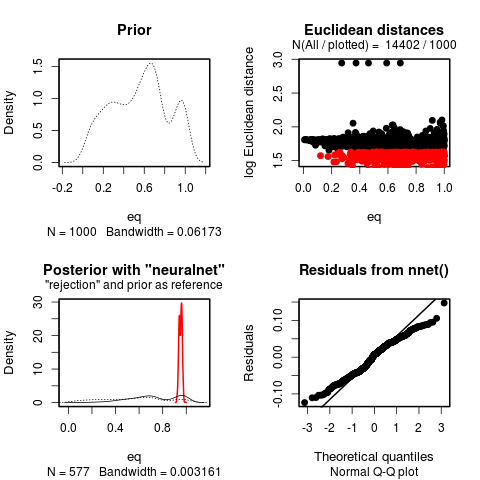

In [10]:
%%R
reseq.abc = abc(target=OBS[3:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,9:17], tol=0.04,
                method="neuralnet")
print(summary(reseq.abc))
#print(res.abc$ss)
hist(reseq.abc)
hist(reseq.abc$adj.values)
#hist(res.abc$dist)
plot(reseq.abc, param=PRIOR[,"X.equil"])


0.709990099956
[ 0.53840884  0.87996169]


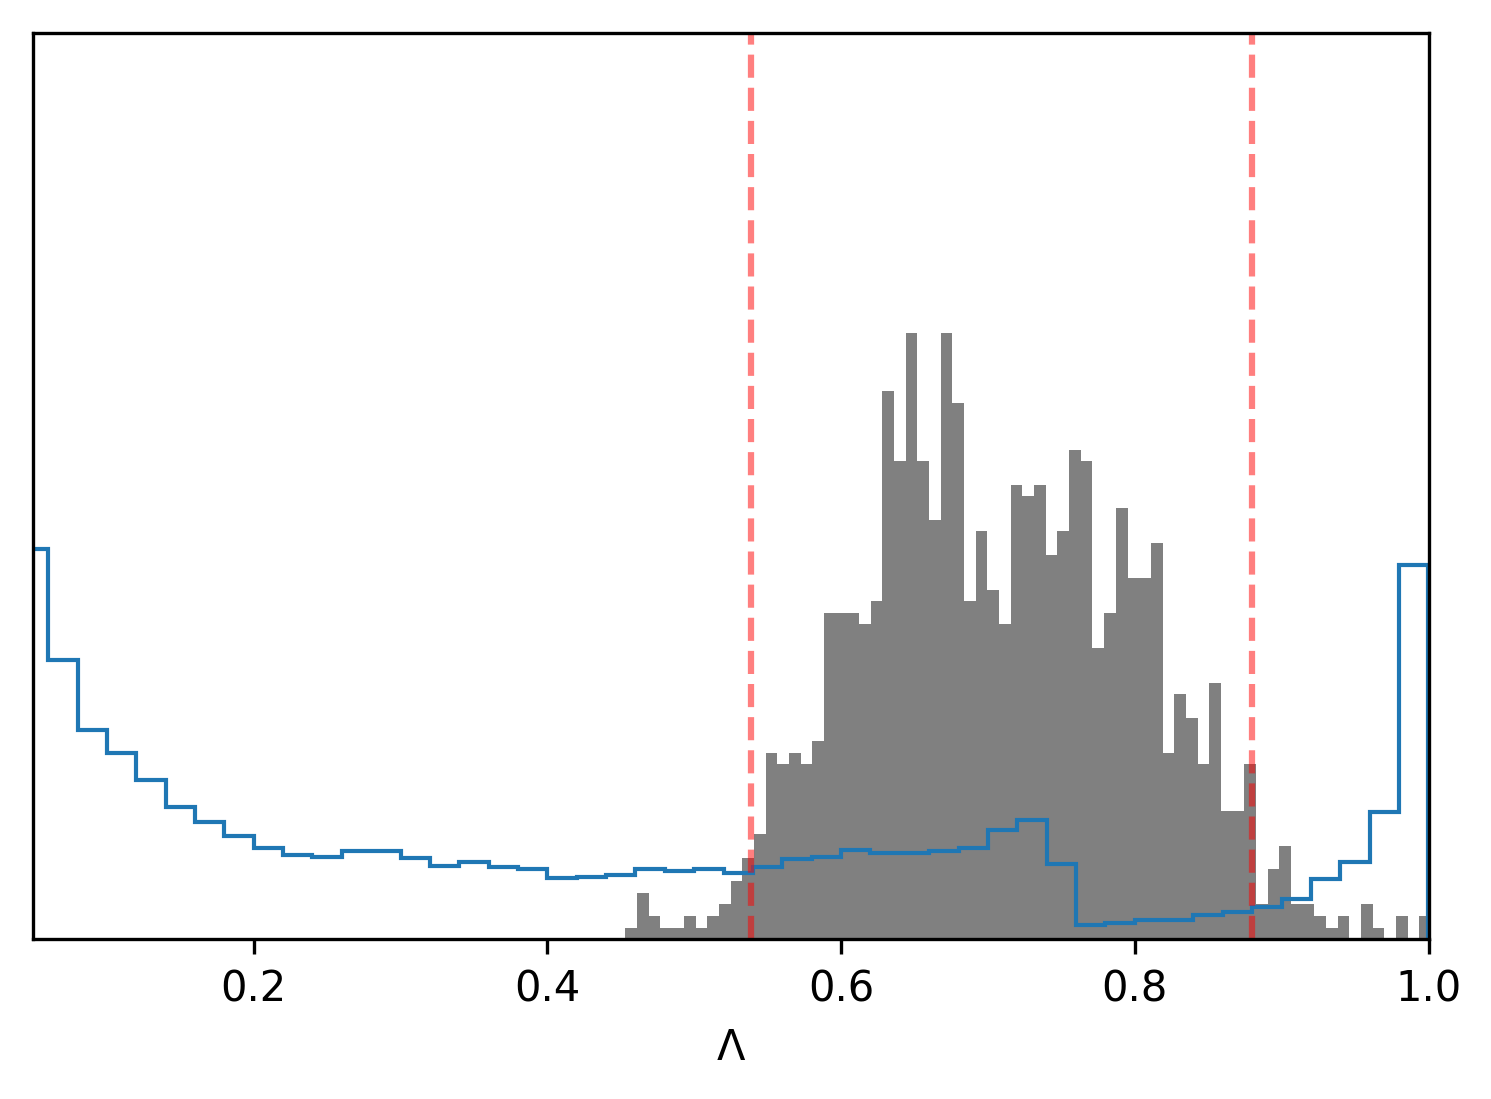

In [147]:
%R -o out out=reseq.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
print(np.mean(eqs))
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)
xs = pymc3.stats.hpd(eqs)[0]
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.5)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.5)
plt.xlabel(u"Λ")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True)
plt.savefig("/home/isaac/gimmeSAD/spider-1d-equilib-posterior.svg")

## Prior goodness of fit test for retained simulations

[25  7  4  1  3  2  4  1  2]
(9,)
(1314, 9)
[[56  8  2  0  1  0  0  0  0]
 [54  7  2  1  0  0  1  0  0]]
(1315, 9)
[25  7  4  1  3  2  4  1  2]
explained variance ratio (first two components): [ 0.97461588  0.01961571]


[]

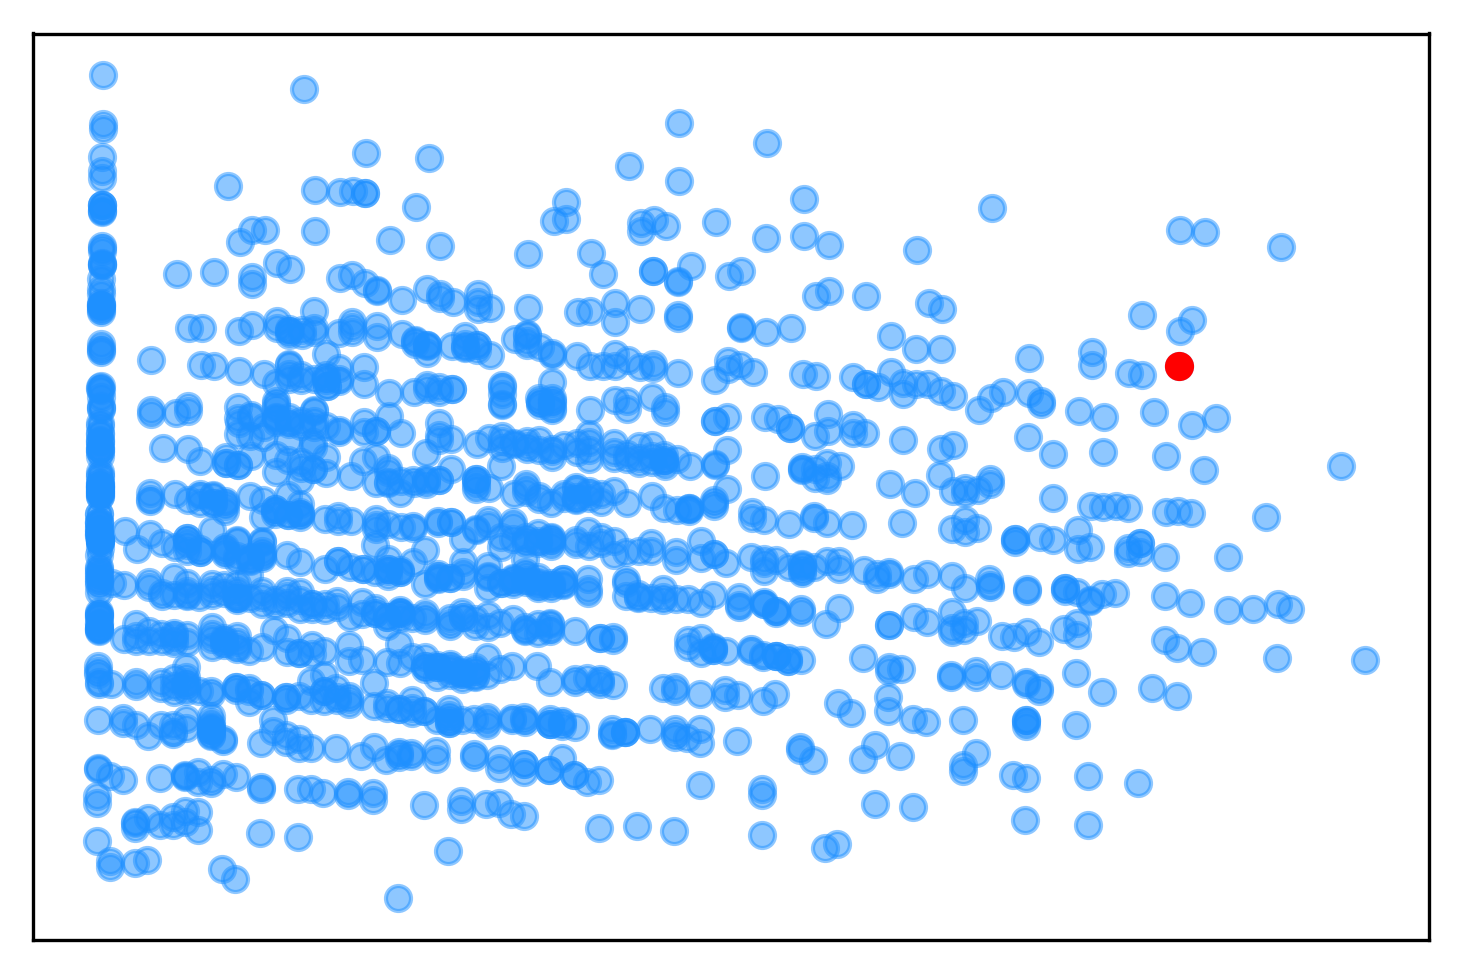

In [77]:
%R -o out out=reseq.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()[2:]])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

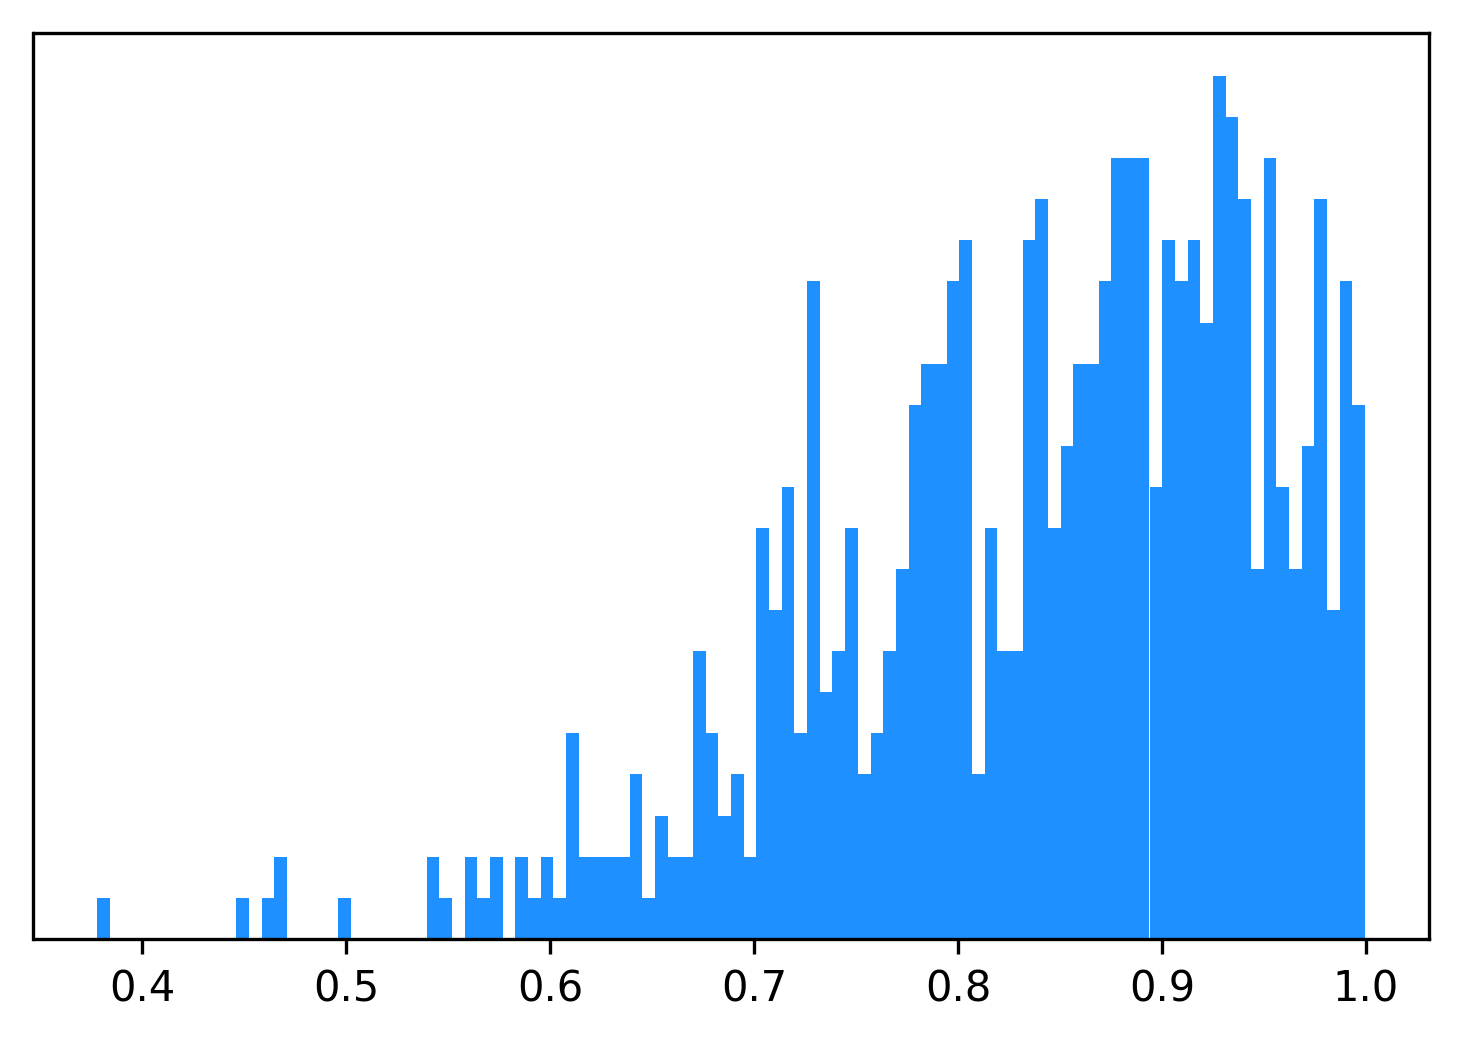

In [98]:
%R -o out out=reseq.abc$adj.values
adj = np.array([x[0] for x in out])
adj = adj[adj < 1]
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(adj, bins=100, color='DodgerBlue', lw=1)

3.73753740868
24.2351484146


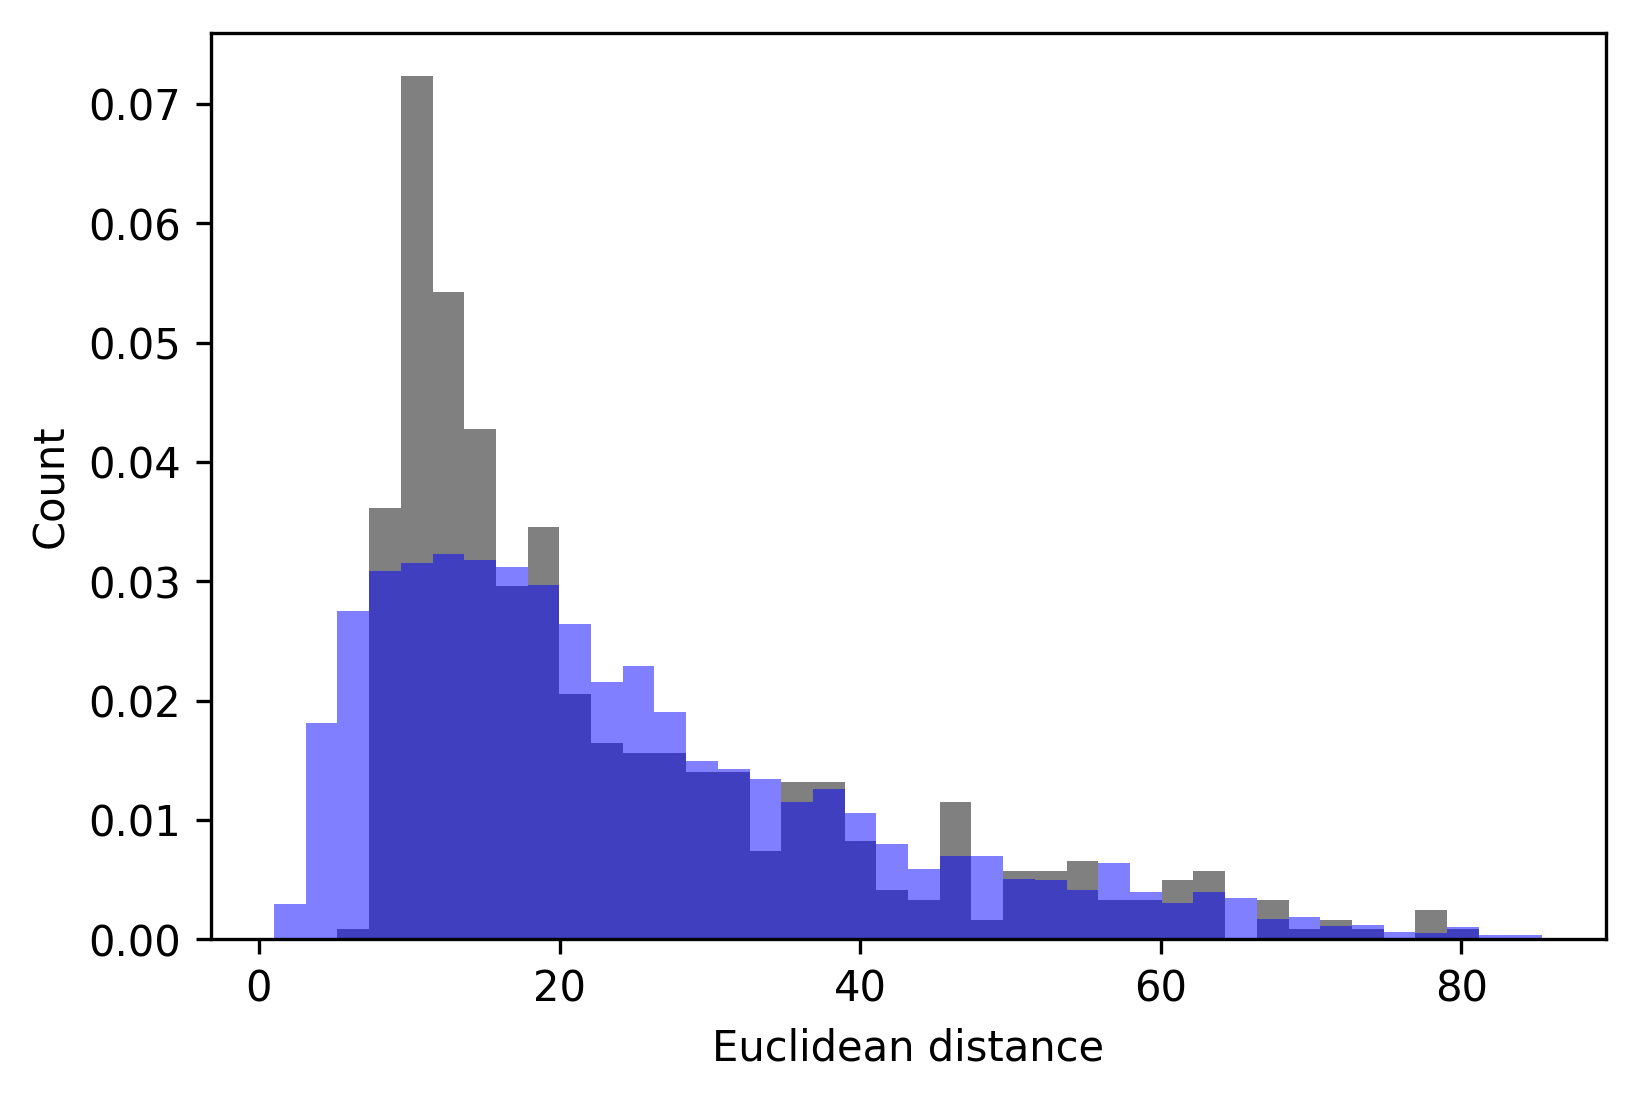

In [20]:
%R -o out out=reseq.abc$ss

from scipy.spatial.distance import euclidean, pdist

OBS = np.array([float(x) for x in open(OBSERVED_FILE).readlines()[1].split()[:1]])[0]
print(OBS)

dist = []
self_dist = pdist(out, metric="euclidean")
print(np.mean(self_dist))
for vec in out:
    dist.append(euclidean(vec, OBS))
fig = plt.figure(dpi=300)
ax = fig.gca()
#ax.get_yaxis().set_ticks([])
bins=np.histogram(np.hstack((dist, self_dist)), bins=40)[1]
n, _, _ = plt.hist(dist, bins, color='grey', lw=1, normed=True)
n, _, _ = plt.hist(self_dist, bins, color='blue', lw=1, normed=True, alpha=0.5)
plt.xlabel("Euclidean distance")
plt.ylabel("Count")
plt.savefig("/home/isaac/gimmeSAD/spider-euclidean.svg")


## Estimate %equil using only shannon

Prediction error based on a cross-validation sample of 100

             eq
0.005 0.4442036
0.01  0.4326860
0.05  0.4296489


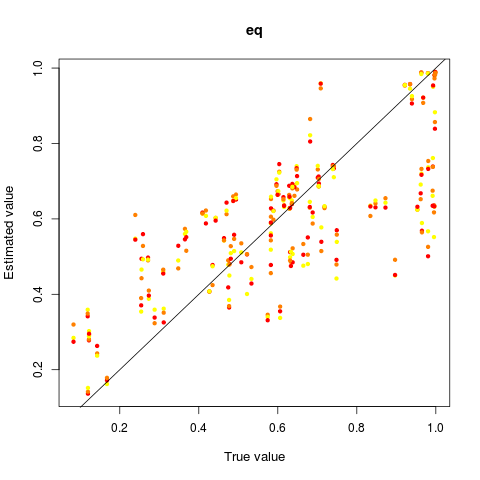

In [69]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

12345
12345
Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.07, method = "neuralnet", numnet = 5, 
    lambda = 0.1)
Data:
 abc.out$adj.values (2299 posterior samples)
Weights:
 abc.out$weights

                           eq
Min.:                  0.3256
Weighted 2.5 % Perc.:  0.4779
Weighted Median:       0.6860
Weighted Mean:         0.7107
Weighted Mode:         0.6956
Weighted 97.5 % Perc.: 1.0093
Max.:                  1.0504
                              eq
Min.:                  0.3255539
Weighted 2.5 % Perc.:  0.4779325
Weighted Median:       0.6860355
Weighted Mean:         0.7107338
Weighted Mode:         0.6956486
Weighted 97.5 % Perc.: 1.0093036
Max.:                  1.0504453


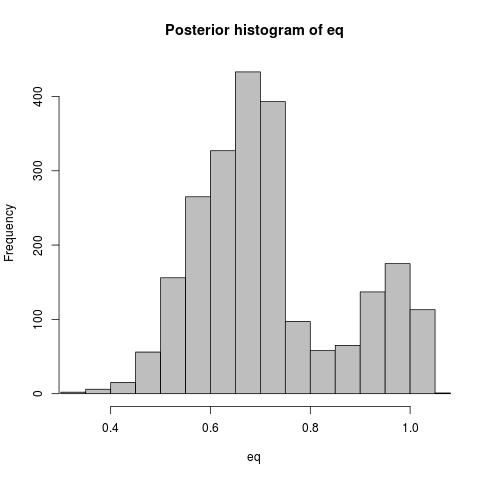

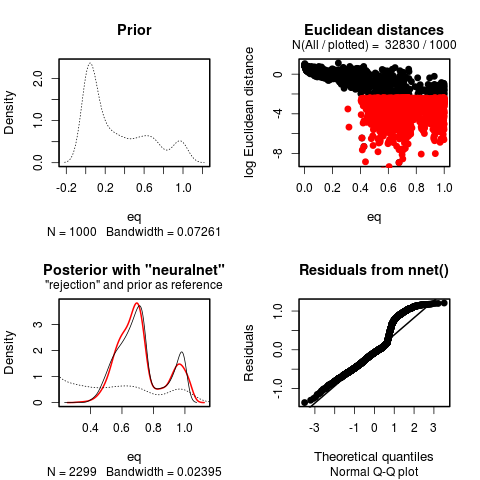

In [143]:
%%R
resshaneq.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.07, 
                    method="neuralnet", lambda=0.1, numnet=5)
print(summary(resshaneq.abc))
hist(resshaneq.abc)
plot(resshaneq.abc, param=PRIOR[,"X.equil"])

0.715803180159
[ 0.50046621  1.03012251]


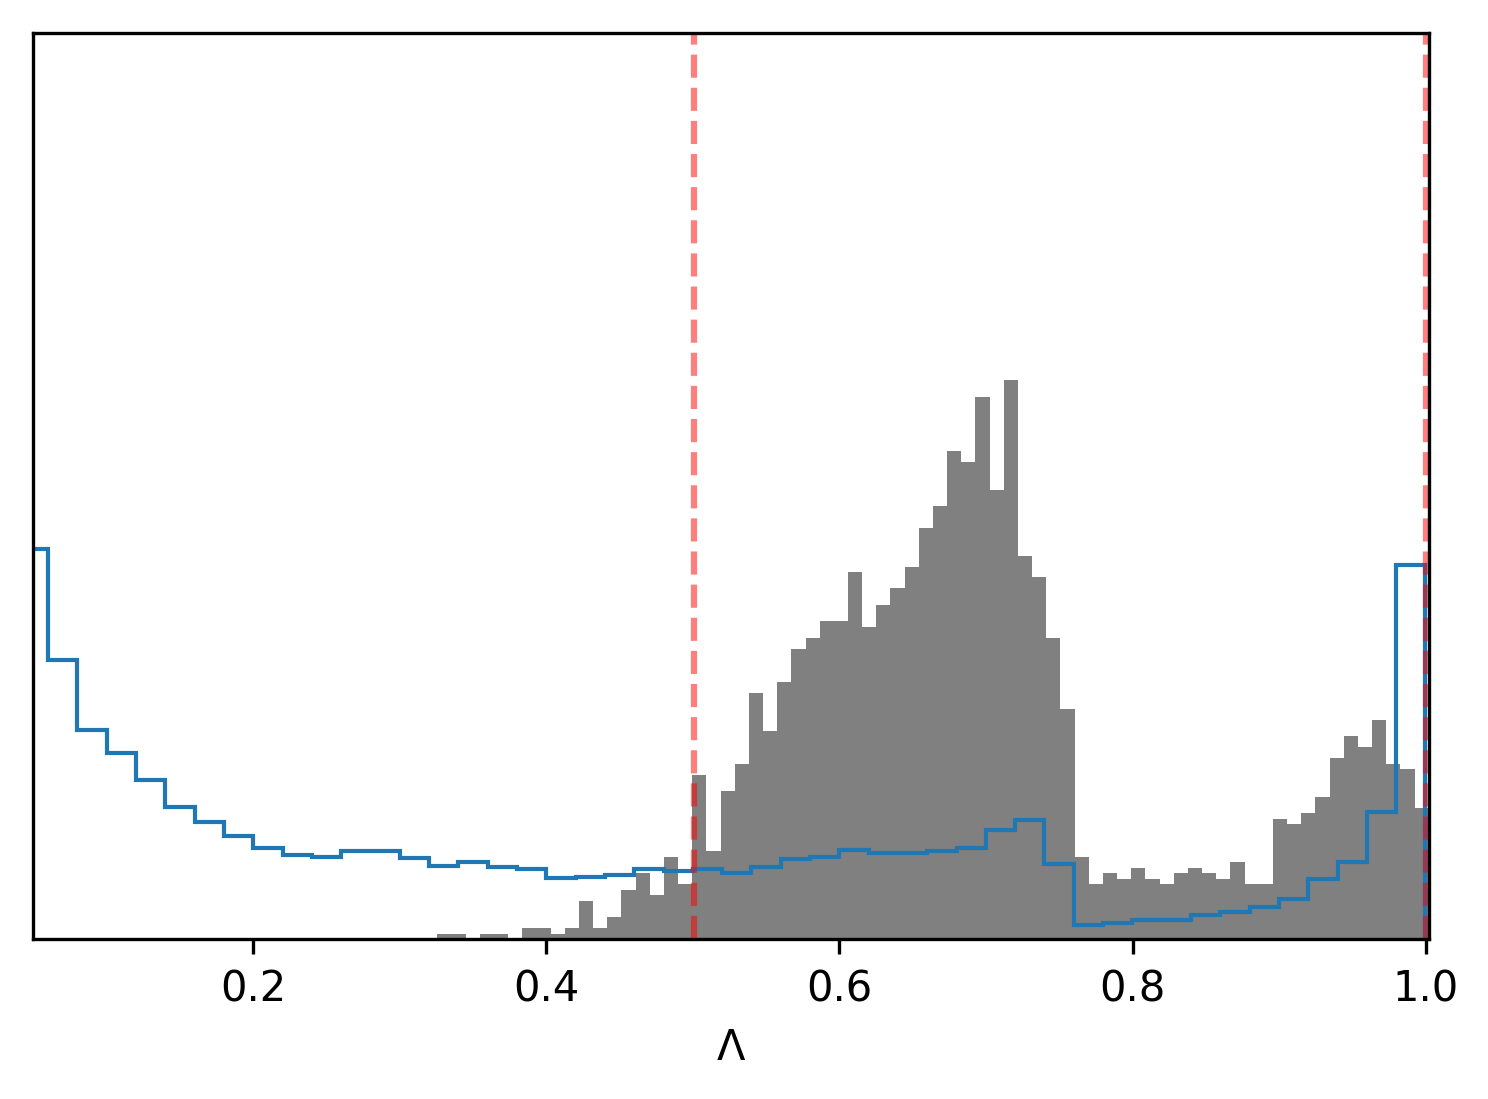

In [144]:
%R -o out out=resshaneq.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
print(np.mean(eqs))
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)
xs = pymc3.stats.hpd(eqs)[0]
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.5)
plt.axvline(min(1, xs[1]), color='r', linestyle='--', alpha=0.5)
plt.xlabel(u"Λ")
plt.xlim((0.05, 1.002))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True)
plt.savefig("/home/isaac/gimmeSAD/spider-shan-equilib-posterior.svg")

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


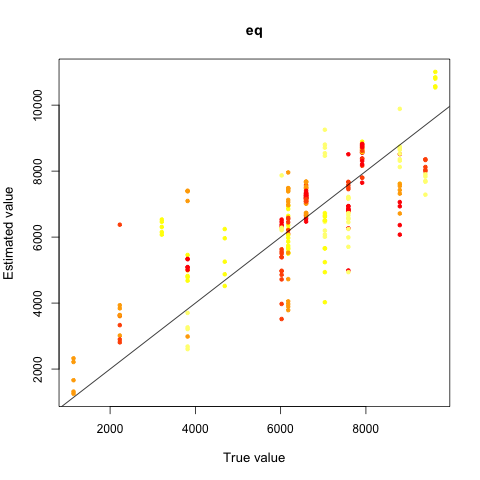

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (5678 posterior samples)
Weights:
 abc.out$weights

                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858
                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858


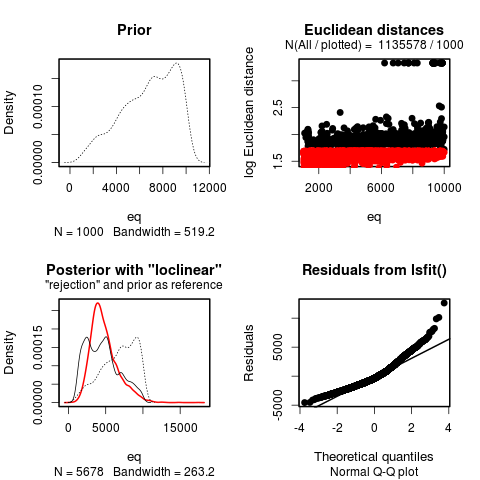

In [134]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS[1:11], param = data.frame(c = PRIOR[, "c"], 
    k = PRIOR[, "K"], eq = PRIOR[, "X.equil"]), sumstat = PRIOR[, 
    7:17], tol = 0.005, method = "rejection", hcorr = FALSE)
Data:
 abc.out$unadj.values (5678 posterior samples)

                      c          k         eq
Min.:            0.0010  1047.0000     0.2413
2.5% Perc.:      0.0017  1352.0000     0.4437
Median:          0.0092  4378.0000     0.7436
Mean:            0.0125  4567.2068     0.7766
Mode:            0.0066  5057.6844     0.9751
97.5% Perc.:     0.0409  9387.0000     0.9969
Max.:            0.0499 10000.0000     0.9999
                        c            k           eq
Min.:        1.017463e-03 1.047000e+03 2.413442e-01
2.5% Perc.:  1.693557e-03 1.352000e+03 4.436640e-01
Median:      9.159525e-03 4.378000e+03 7.435892e-01
Mean:        1.246531e-02 4.567207e+03 7.766224e-01
Mode:        6.591364e-03 5.057684e+03 9.751154e-01
97.5% Perc.: 4.094353e-02 9.387000e+03 9.968682e-01
Max.:        4.98

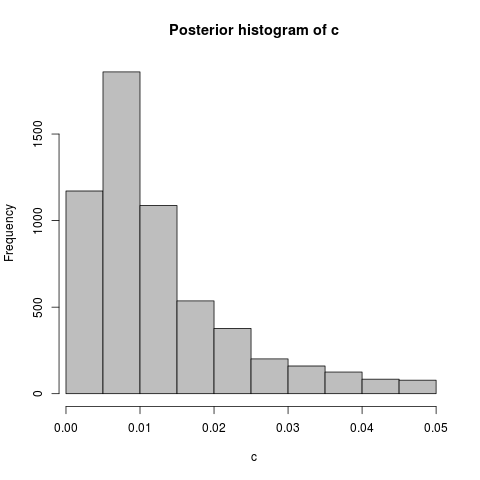

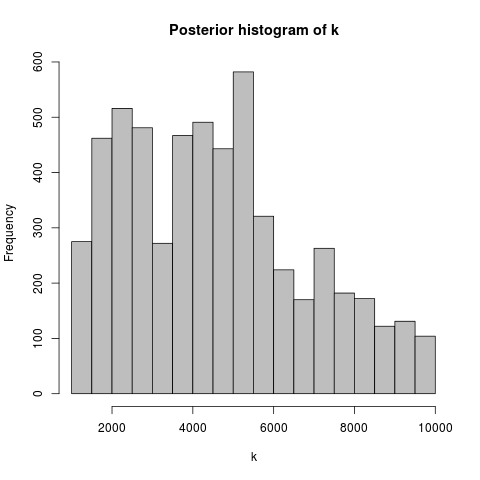

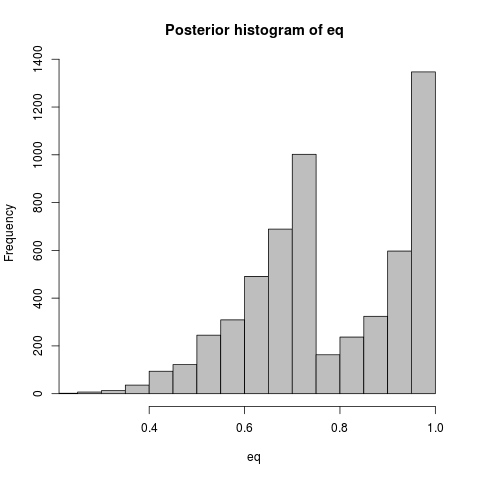

In [152]:
%%R
res.abc = abc(target=OBS[1:11], param=data.frame(c=PRIOR[,"c"], k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], hcorr=FALSE, tol=0.005, method="rejection")
print(summary(res.abc))
hist(res.abc)

#plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))

## All crap below here

In [55]:
from collections import Counter

f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

c = Counter([])
unif_dat = []
for line in lines:
    try:
        shan_val = line[6][:3]
        if shan_val in c:
            if c[shan_val] > 1000:
                continue
        c.update([shan_val])
        unif_dat.append("\t".join(line))
    except:
        pass
print(c)
with open("/tmp/unifprior.txt", 'w') as outfile:
    outfile.write("\n".join(unif_dat))

Counter({'1.4': 1001, '1.5': 1001, '1.6': 1001, '1.7': 1001, '1.2': 1001, '1.3': 1001, '1.8': 1001, '1.9': 1001, '3.6': 1001, '3.7': 1001, '3.4': 1001, '3.5': 1001, '3.2': 1001, '3.3': 1001, '3.0': 1001, '3.1': 1001, '2.3': 1001, '2.2': 1001, '2.1': 1001, '2.0': 1001, '2.7': 1001, '2.6': 1001, '3.8': 1001, '2.4': 1001, '4.1': 1001, '4.0': 1001, '2.5': 1001, '3.9': 1001, '2.9': 1001, '2.8': 1001, '1.1': 848, '1.0': 690, '0.9': 394, '0.8': 251, '4.2': 199, '0.6': 137, '0.7': 126, '0.5': 61, '-0.': 46, '0.4': 29, '0.3': 13, '0.2': 6, 'sha': 1})


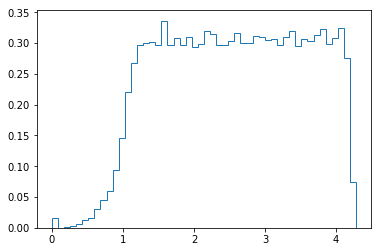

In [64]:
## Get shannon prior
f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass

n, bins, patches = plt.hist(shan_dat, bins=50, histtype="step", normed=True)

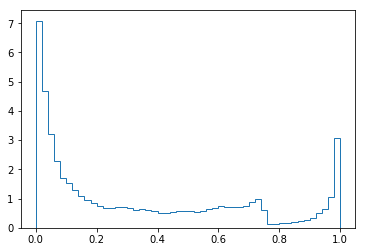

In [87]:
## Get lambda prior
f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass

n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

In [49]:
from collections import Counter

c = Counter([])
c.update(["1.1"])
if "1.1" in c:
    print("wat")
    print(c["1.1"])
print(c)

wat
1
Counter({'1.1': 1})
